In [16]:
import os

import kagglehub

path = kagglehub.dataset_download("sachinkumar413/diabetic-retinopathy-dataset")

print("Path to dataset files:", path)


print("Files in dataset:", os.listdir(path))

Path to dataset files: /kaggle/input/diabetic-retinopathy-dataset
Files in dataset: ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR']


In [20]:
import pandas as pd
import numpy as np

data_dir = path

labels = os.listdir(data_dir)
image_paths = []
image_labels = []

for label in labels:
    class_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        image_labels.append(label)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": image_labels
})

print(df.sample(5))
print("\nClass counts:\n", df['label'].value_counts())


                                             image_path        label
1705  /kaggle/input/diabetic-retinopathy-dataset/Mod...  Moderate DR
423   /kaggle/input/diabetic-retinopathy-dataset/Hea...      Healthy
1612  /kaggle/input/diabetic-retinopathy-dataset/Mod...  Moderate DR
421   /kaggle/input/diabetic-retinopathy-dataset/Hea...      Healthy
2444  /kaggle/input/diabetic-retinopathy-dataset/Mil...      Mild DR

Class counts:
 label
Healthy           1000
Moderate DR        900
Mild DR            370
Proliferate DR     290
Severe DR          190
Name: count, dtype: int64


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_mapping)
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label_idx'], random_state=42)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)
class_weights_dict = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(2.909090909090909), 1: np.float64(0.55), 2: np.float64(0.6111111111111112), 3: np.float64(1.4852320675105486), 4: np.float64(1.89247311827957)}


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1760 validated image filenames belonging to 5 classes.
Found 440 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers[-30:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

model.summary()

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,279,365 (187.99 MB)

 Trainable params: 49,226,245 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_dr_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4734 - loss: 3.1334 

55/55 ━━━━━━━━━━━━━━━━━━━━ 1425s 25s/step - accuracy: 0.4741 - loss: 3.1159 - val_accuracy: 0.3636 - val_loss: 3.0261
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1342s 24s/step - accuracy: 0.5846 - loss: 1.0229 - val_accuracy: 0.3636 - val_loss: 1.8873
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1336s 24s/step - accuracy: 0.5866 - loss: 0.9423 - val_accuracy: 0.3295 - val_loss: 1.7895
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1357s 25s/step - accuracy: 0.6135 - loss: 0.9013 - val_accuracy: 0.3227 - val_loss: 1.6255
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1358s 25s/step - accuracy: 0.6477 - loss: 0.8434 - val_accuracy: 0.3545 - val_loss: 1.8033
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1380s 25s/step - accuracy: 0.6418 - loss: 0.8123 - val_accuracy: 0.1659 - val_loss: 2.0972


Model saved successfully!


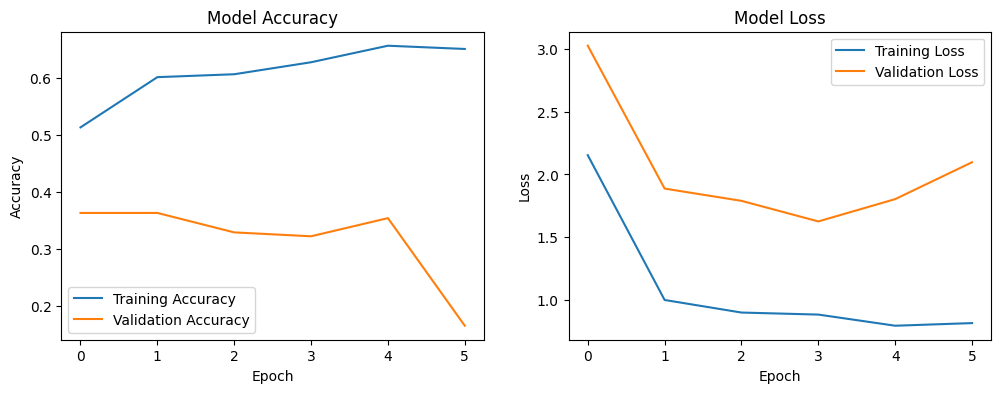


Test Accuracy: 0.3636
Test Loss: 3.0205


In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


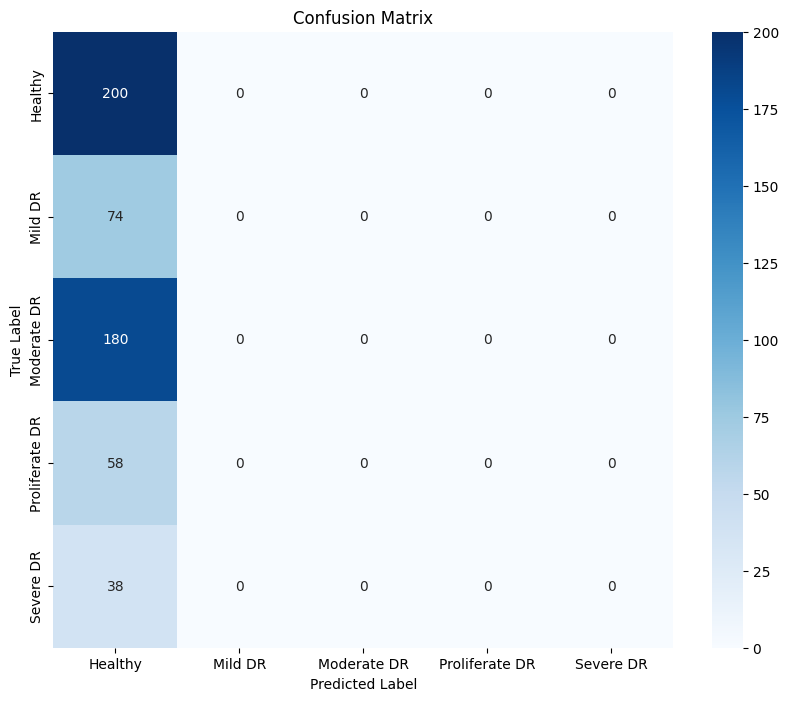

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test_generator.classes

y_pred_probs = model.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step
                precision    recall  f1-score   support

       Healthy       0.36      1.00      0.53       200
       Mild DR       0.00      0.00      0.00        74
   Moderate DR       0.00      0.00      0.00       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.00      0.00      0.00        38

      accuracy                           0.36       550
     macro avg       0.07      0.20      0.11       550
  weighted avg       0.13      0.36      0.19       550



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


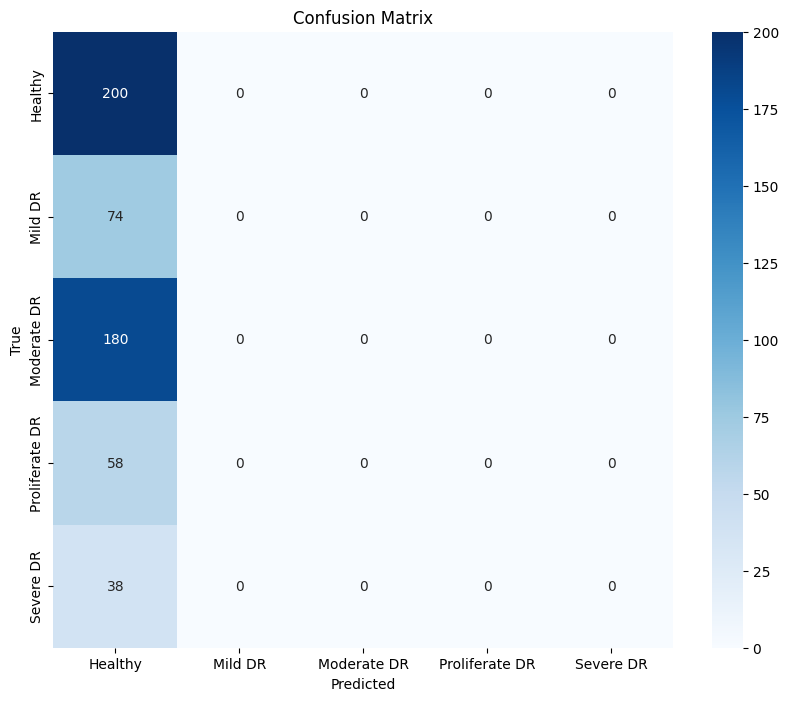

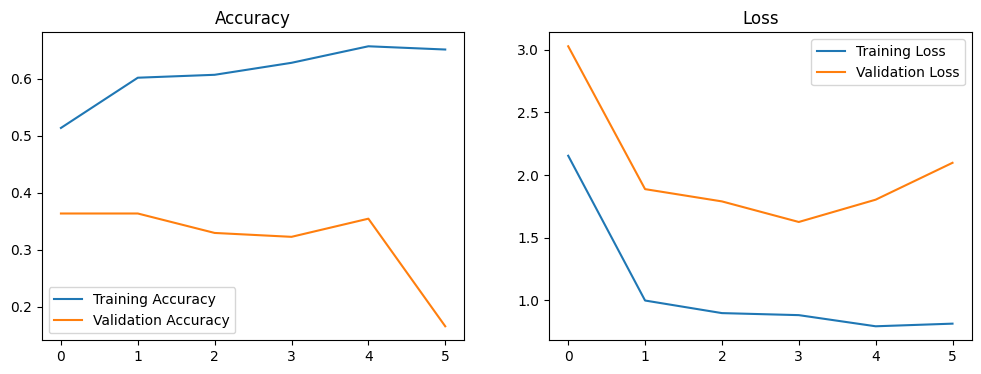


Test Accuracy: 0.3636
Test Loss: 3.0205


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [29]:
model.save("resnet_dr_model.h5")
print("ResNet model saved as resnet_dr_model.h5")

ResNet model saved as resnet_dr_model.h5
